# 4. Support vector regression

## 4.1 Imports 

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings
import pylab

from ipynb.fs.full.Functions import plotValCurve, plotLearningCurve
from numpy import loadtxt
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from statsmodels.api import qqplot

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
PreparedFeatures = pd.read_csv('../Data/PreparedFeatures.csv', sep='\t')
X_train = loadtxt('../Data/X_train.csv', delimiter=',')
y_train = loadtxt('../Data/y_train.csv', delimiter=',')
X_test = loadtxt('../Data/X_test.csv', delimiter=',')
y_test = loadtxt('../Data/y_test.csv', delimiter=',')

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9550, 39), (9550,), (2388, 39), (2388,))

In [4]:
mse = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

## 4.2 Learning process visualization

### 4.2.1 Ploting learning curve, model scalability and performance

<module 'matplotlib.pyplot' from 'C:\\Users\\brtkr\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

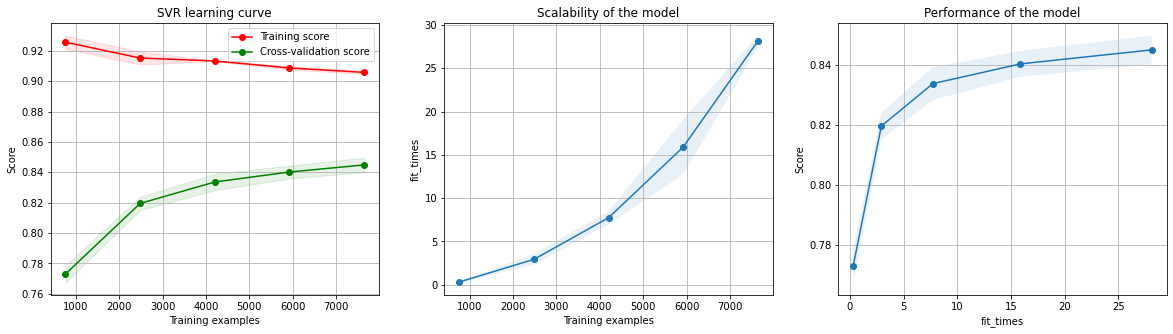

In [5]:
plotLearningCurve(estimator=SVR(), title = "SVR learning curve", X=X_train,
                  y=y_train, cv=5, n_jobs=-1)

In contrast to random forrest, training score is very high when using few samples and decreses along with increasing samples number. Training and validation curves are convergent along the x-axis. Model needs more examples to reach score similar to random forrest regressor performance. Model scales quadratically which significantly increases the time needed for training. 

### 4.2.2 C parameter validation curve

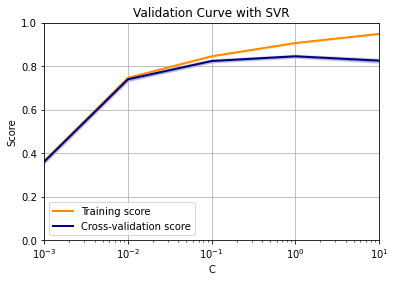

In [6]:
plotValCurve(estimator=SVR(), X = X_train, y = y_train, param_name='C',
             param_range=np.array([0.001, 0.01, 0.1, 1., 10.]), cv=5)

Validation curve for C parameter shows that optimial parameter value is around 1. When higher score tends to fall down.

### 4.2.3 Gamma validation curve

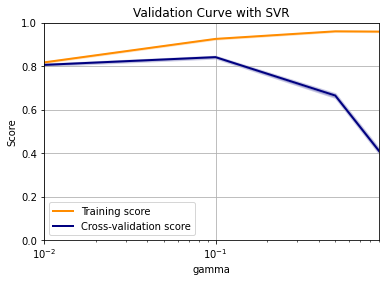

In [7]:
plotValCurve(estimator=SVR(), X = X_train, y = y_train, param_name='gamma',
             param_range=np.array([0.01, 0.1, 0.5, 0.9]), cv=3)

Gamma validation curve is more stable in lower values range and drops drastically after exceeding 0.1. In this case optimal parameter is somwhere around previously mentioned value.

## 4.3 Hyperparameter tuning 

### 4.3.1 Grid search kernel selection 

In [8]:
svr_grid = SVR()

gridCV = GridSearchCV(svr_grid, {'kernel':['linear', 'poly', 'rbf']},
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) mse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'kernel': 'rbf'}
Best (lowest) mse in cross-validation:-0.03392911657534166


Default kernel gives best results in grid search cross-validation so won't be changed.

### 4.3.2 Grid search C and gamma tuning

In [9]:
svr_grid = SVR()

gridCV = GridSearchCV(svr_grid, {'C':[0.4, 0.6, 0.8, 1., 1.2, 1.4], 'gamma':[0.08, 0.09, 0.1]}, 
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) mse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 0.8, 'gamma': 0.08}
Best (lowest) mse in cross-validation:-0.034010157374436224


In [10]:
svr_grid = SVR()

gridCV = GridSearchCV(svr_grid, {'C':[1], 'gamma':['scale']}, 
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) mse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 1, 'gamma': 'scale'}
Best (lowest) mse in cross-validation:-0.03392911657534166


Second cross-validation uses default settings, it looks like scale is most accurate for gamma so only C will be tuned. 

In [11]:
svr_grid = SVR()

gridCV = GridSearchCV(svr_grid, {'C':[0.5, 0.6, 0.7, 1.], 'gamma':['scale']}, 
                      cv=5, n_jobs=-1, scoring=mse)

gridCV.fit(X_train, y_train)

print('Best parameters:' + str(gridCV.best_params_))
print('Best (lowest) mse in cross-validation:' + str(gridCV.best_score_))

Best parameters:{'C': 0.7, 'gamma': 'scale'}
Best (lowest) mse in cross-validation:-0.03389958289298959


C equal 0.7 gives better cross-validation results.

## 4.4 Tuned model evaluation

In [12]:
svr = SVR(C=0.7)

svr.fit(X_train, y_train)

SVR(C=0.7)

In [13]:
y_pred = svr.predict(X_test)

### 4.4.1 RMSE

In [14]:
metrics.mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)

0.1750005632863343

### 4.4.2 Adjusted R-squared

In [15]:
adj_r2 = 1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
adj_r2

0.8558242955239714

Despite little bit lower performance on test set in final model training, C will stay set at 0.7. With this setting model is better at generalization and less tends to overfit. 

### 4.4.3 Residuals analysis

In [16]:
residuals = y_test - y_pred
residuals

array([ 0.14277092,  0.12442243,  0.10072997, ..., -0.19240366,
       -0.2538849 , -0.01553331])

#### 4.4.3.1 Residuals distribution 

<AxesSubplot:ylabel='Density'>

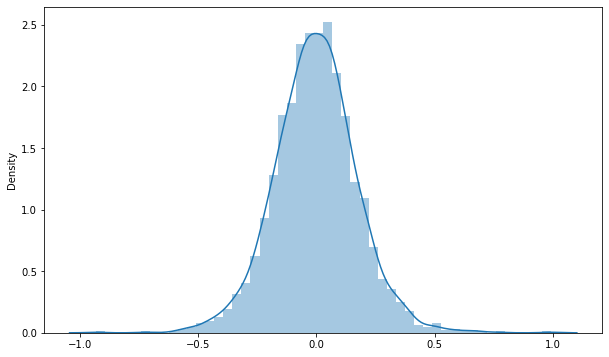

In [17]:
plt.subplots(figsize=(10,6))
sns.distplot(residuals)

No bias suggest that model random component is not correlated with estimated value, which is regression model assumption.

#### 4.4.3.2 Residuals Q-Q plot

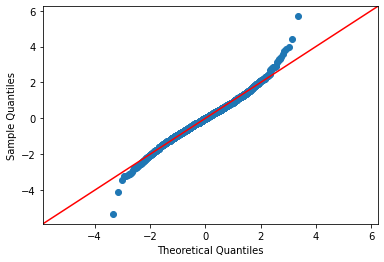

In [18]:
qq = residuals.copy()
m = qq.mean()
st = qq.std()

for i in range(0, len(qq),1):
    qq[i] = (qq[i]-m)/st
    
qqplot(qq, line='45')
pylab.show()

Direction of tails deviation is caused by small amount of huge error. 

#### 4.4.3.3 Heteroskedascity plot

<AxesSubplot:>

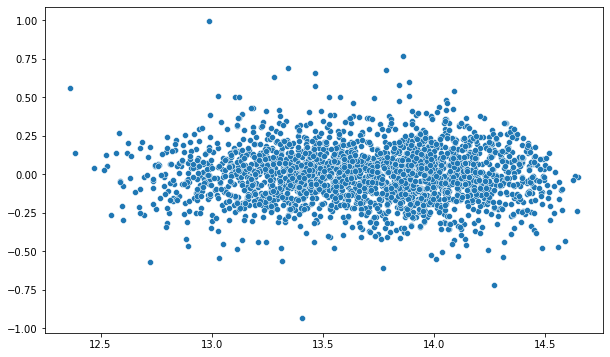

In [19]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x = y_pred, y = residuals)

Random dispersion indicates that variances of error terms are constant, and error is homoskedastic.

#### 4.4.3.4 Scale location plot

Text(0.5, 0, 'Fitted value')

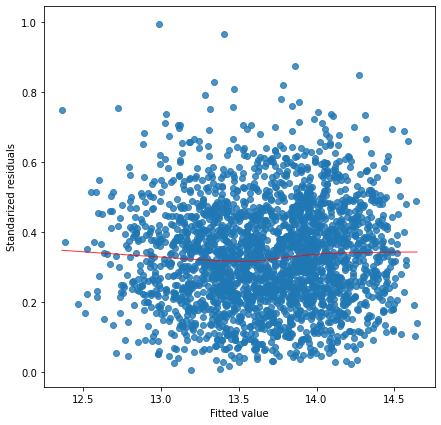

In [20]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(y_pred.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

Residuals are spread equally along ranges of predictors. Graph also indicated that heteroskedasticity does not appears. Here also residuals analysis does not indicate that the assumptions of the model are not met.

In [21]:
svr_saved_model = pickle.dump(svr, open(r'..\Models\svr.pkl','wb'))